# HR - Аналитика 📈

**Описание проекта:** с помощью машинного обучения быстрее и точнее ответить на вопросы бизнеса, а именно: помочь HR-аналитикам оптимизировать управление персоналом и избежать финансовых потерь и оттока сотрудников. 

**Цель проекта:** Необходимо решить 2 задачи:

-  Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

- Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Содержание**<a id='toc0_'></a> 

  **Первая задача проекта**
1. [Подготовка данных](#toc1_)                                  
  1.1 [Установка библиотек и конфигурации](#toc1_1_)    
  1.2 [Функции, используемые в проекте](#toc1_2_) 
  
2. [Предобработка данных и исследовательский анализ данных(EDA)](#toc2_)         
  2.1 [Датафрейм market_file](#toc2_1_)    
  2.2 [Датафрейм train_df (train_job_satisfaction_rate.csv)](#toc2_2_)    
  2.3 [Датафрейм y_test(test_target_job_satisfaction_rate.csv ) ](#toc2_3_)                        

3. [Корреляционный анализ](#toc3_)  

4. [Построение моделей](#toc4_)                           
  4.1 [Подготовка данных и построение пайплайнов](#toc4_1_)                     
  4.2 [Анализ остатков](#toc4_2_)                     
  
5. [Анализ важности признаков](#toc5_)

**Вторая задача проекта**

6. [Предобработка данных и исследовательский анализ данных(EDA)](#toc6_)         
  6.1 [Датафрейм train_df_2 (train_quit.csv) ](#toc6_1_)    
  6.2 [Датафрейм y_test2 (test_target_quit)](#toc6_2_)    
  6.3 [Портрет уволившегося сотрудника](#toc6_3_)                                                                            
  6.4 [Влияние уровня удовлетворенности на увольнение](#toc6_4_)
  6.5 [Добавление нового признака](#toc6_5_)                                                               
 
7. [Корреляционный анализ](#toc7_)  

8. [Построение моделей](#toc8_)                                                                       
                 
9. [Анализ важности признаков](#toc9_)

10. [Общий вывод](#toc10_)

****Первая задача проекта****

## <a id='toc1_'></a> Подготовка данных[&#8593;](#toc0_)

### <a id='toc1_1_'></a>Установка библиотек  и конфигурации [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):  
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else: 
    pass
    %pip install --upgrade numpy -q   

%pip install --force-reinstall -v "matplotlib==3.8.0" -q

%pip install --upgrade phik -q
%pip install --upgrade prettytable -q
%pip install --upgrade termcolor -q
%pip install --upgrade seaborn -q
%pip install --upgrade pandas -q
%pip install --upgrade statsmodels -q
%pip install --upgrade scikit-learn -q
%pip install --upgrade shap -q
%pip install --upgrade imbalanced-learn -q
%pip install --upgrade optuna -q

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

from os.path import exists

# preprocessing
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder)
from sklearn.impute import (
    SimpleImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression)
from sklearn.svm import (
    SVR,
    SVC)
from sklearn.neighbors import (
    KNeighborsRegressor,
    KNeighborsClassifier)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier)
from sklearn.ensemble import (
    RandomForestClassifier)
from sklearn.dummy import (
    DummyClassifier, 
    DummyRegressor)
# metrics
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    ConfusionMatrixDisplay)

# additional tools
from sklearn.inspection import permutation_importance
from phik import phik_matrix 
from prettytable import PrettyTable
from termcolor import colored

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

### <a id='toc1_2_'></a>Функции, используемые в проекте [&#8593;](#toc0_)

In [5]:
def get_dataframe(paths: list[str]) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue
        
        try:
            df = pd.read_csv(_path)
        except:
            continue
        
        if df is None:
            continue
        
        return df
    
    raise FileNotFoundError('No paths are valid and/or for correct csv file.')

In [6]:
def smape_function(y_true: np.ndarray, y_pred: np.ndarray) -> float:    
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100

smape = make_scorer(smape_function, greater_is_better=False)

In [7]:
def print_nans_table(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Признаки', 'Пропущенное количество значений']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'blue' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.1%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [8]:
def the_basic_plots(df: pd.DataFrame,
                    column: str,
                    column_description: str,
                    bins: int = 25
                    ) -> None:
    
    _, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 6))

    sns.boxplot(data=df, x=column, ax=ax1)
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.histplot(data=df, x=column, bins=bins, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()
    ax2.set_ylabel('Количество')

    plt.suptitle(f'Информация о колонке {column_description}', fontsize=18)
    plt.tight_layout()

    plt.show()

In [9]:
def plot_pie_chart(series: pd.Series, title: str) -> None:
    table_1 = series.value_counts()
    data, labels = table_1.values, table_1.index
    plt.pie(data, labels=labels, autopct='%.0f%%')
    plt.title(title)
    plt.show()

In [10]:
def count_plot_(column: str, data: pd.DataFrame) -> None:
    ax = sns.countplot(x = column,  data = data)
    plt.grid()
    ax.bar_label(ax.containers[0])
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f'Информация о колонке {column}', fontsize=12)
    plt.show()

In [11]:
def get_plots_about_residuals(y_true: np.array, y_pred: np.array) -> None:
    res = y_true - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.histplot(res, ax=ax1)
    ax1.set_xlabel('Остатки')
    ax1.set_ylabel('Количество')
    ax1.axvline(x=0, color='green', lw=3, ls='-', label='Нулевое значение')
    ax1.axvline(x=res.mean(), color='red', lw=3, ls='--', label='Среднее значение остатков')
    ax1.legend()
    
    sns.scatterplot(x=y_pred, y=res, ax=ax2)
    ax2.set_xlabel('Предсказанные значение')
    ax2.set_ylabel('Остатки')
    
    fig.suptitle('Информация об остатках')

In [12]:
def addlabels(data,x,y) -> None:
    for i in range(len(data)):
        plt.text(i, y[i], y[i]//2, ha = 'center')

**Первая задача проекта**

## <a id='toc2_'></a> Предобработка и исследовательский анализ данных(EDA) [&#8593;](#toc0_)

### <a id='toc2_1_'></a>Датафрейм train_df (train_job_satisfaction_rate.csv) [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [13]:
train_df = get_dataframe(['/datasets/train_job_satisfaction_rate.csv'])

In [14]:
train_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


2. Проверим типы данных:

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Типы данных установлены корректно, однако уже видно, что есть пропуски

3. Рассмотрим пропуски подробнее:

In [16]:
print_nans_table(train_df)

+-----------------------+---------------------------------+
|        Признаки       | Пропущенное количество значений |
+-----------------------+---------------------------------+
|           id          |             0 (0.0%)            |
|        workload       |             0 (0.0%)            |
|    employment_years   |             0 (0.0%)            |
|    last_year_promo    |             0 (0.0%)            |
|  last_year_violations |             0 (0.0%)            |
| supervisor_evaluation |             0 (0.0%)            |
|         salary        |             0 (0.0%)            |
| job_satisfaction_rate |             0 (0.0%)            |
|         level         |             4 (0.1%)            |
|          dept         |             6 (0.1%)            |
+-----------------------+---------------------------------+


In [17]:
_mask = (train_df['level'].isna()) | (train_df['dept'].isna())
_mask.sum()
train_df[_mask]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Видим, что пропуски находятся в столбцах должности и отдела, в сумме их 10 штук, скорее всего возникли из-за человеческого фактора при заполнении информации. Заполним пропуске дальше в пайплайне. 

4. Посмотрим на дубликаты:

In [18]:
train_df.duplicated().sum()

0

Дубликатов полных нет, значит можем за индекс принять столбец *id*:

In [19]:
train_df = train_df.set_index('id').sort_index()

Еще раз проверим дубликаты:

In [20]:
train_df.duplicated().sum()

245

Удалим данные дубликаты после исследовательского анализа данных

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


**Далее перейдем к исследованию распределений значений по столбцам(EDA).**

1. Столбец *dept*

In [22]:
train_df['dept'].value_counts()

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64

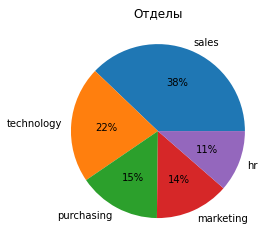

In [23]:
plot_pie_chart(train_df['dept'], 'Отделы')

В отделе продаж большинство сотрудников: все верно, без продаж не будет прибыли.

2. Столбец *level*

In [24]:
train_df['level'].value_counts()

level
junior    1894
middle    1744
sinior     358
Name: count, dtype: int64

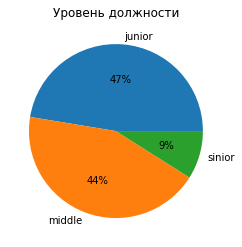

In [25]:
plot_pie_chart(train_df['level'], 'Уровень должности')

Здесь все так же в рамках нормы

3. Столбец *workload*

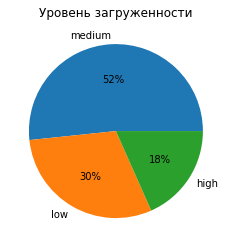

In [26]:
plot_pie_chart(train_df['workload'], 'Уровень загруженности')

Корреляции с уровнями должностей на первый взгляд не наблюдаем, однако оптимизировать работу компании "Работа с заботой" все-таки можно уменьшив количество слабо загруженных людей, усреднив показатели

4. Столбец *employment_years*

In [27]:
train_df['employment_years'].value_counts()

employment_years
1     966
2     785
3     483
4     384
5     380
7     301
6     287
8     193
9     130
10     91
Name: count, dtype: int64

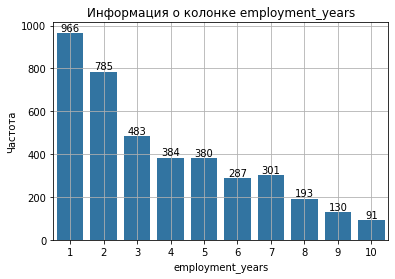

In [28]:
count_plot_('employment_years', train_df)

Вполне реальная картина, однако, в таких ситуациях ожидается пуассоновское распределение, но видимо есть связь с временем проведения исследования и конкретной выборкой данных.

5. Столбец *last_year_promo*

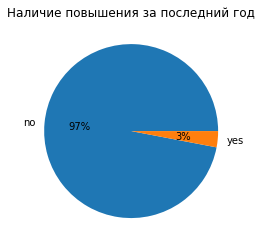

In [29]:
plot_pie_chart(train_df['last_year_promo'], 'Наличие повышения за последний год')

Большинство людей не получали повышений за последний год, это может влиять на уровень удовлетворенности напрямую субъективно

6. Столбец *last_year_violations*

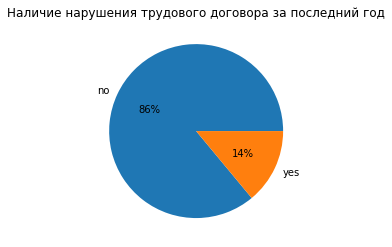

In [30]:
plot_pie_chart(train_df['last_year_violations'], 'Наличие нарушения трудового договора за последний год')

Немало людей нарушали трудовой договор за последний год. Внимательнее отнесемся к этому признаку, он может быть "утечкой", так как в некотором роде может являться следствием уровня удовлетворенности.

7. Столбец *salary*

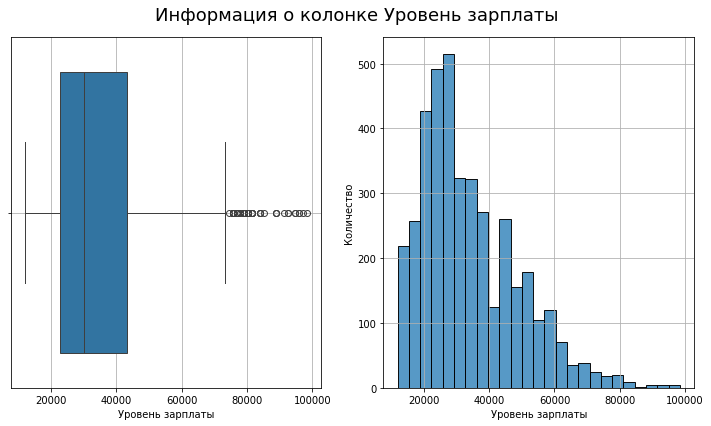

In [31]:
the_basic_plots(train_df, 'salary', 'Уровень зарплаты')

Вполне реальное распределение похожее на пуассоновское.

8. Столбец *supervisor_evaluation*

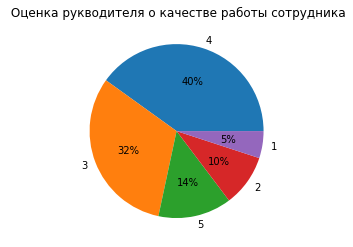

In [32]:
plot_pie_chart(train_df['supervisor_evaluation'], ' Оценка рукводителя о качестве работы сотрудника')

Большинством сотрудников руководители удовлетворены

9. Столбец *job_satisfaction_rate*

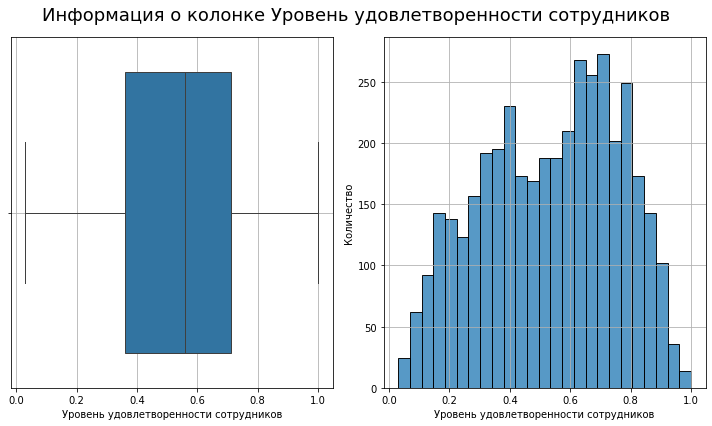

In [33]:
the_basic_plots(train_df, 'job_satisfaction_rate', 'Уровень удовлетворенности сотрудников')

Распределение уровня удовлетворенности похоже на нормальное с небольшим смещением вправо, что все-таки лучше для компании.

**Вывод**:

Провели первичную предобработку данных, обработали дубликаты и пропуски(их оказалось 10, заполним мы их в пайпланйах). Присутствуют признаки разного типа: категориальные (среди которых есть как номинальные, так и порядковые) и числовые.

Целевой признак имеет унимодальное почти нормальное распределение со смещением вправо.

### <a id='toc2_2_'></a>Датафрейм X_test(test_features.csv) [&#8593;](#toc0_)

1. Загружаем датафрейм и смотрим первично информацию о нем

In [34]:
X_test = get_dataframe(['/datasets/test_features.csv'])

In [35]:
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


2. Проверим типы данных:

In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Типы данных верные. Есть пропуски, рассмотрим их.

3. Пропуски:

In [37]:
print_nans_table(X_test)

+-----------------------+---------------------------------+
|        Признаки       | Пропущенное количество значений |
+-----------------------+---------------------------------+
|           id          |             0 (0.0%)            |
|        workload       |             0 (0.0%)            |
|    employment_years   |             0 (0.0%)            |
|    last_year_promo    |             0 (0.0%)            |
|  last_year_violations |             0 (0.0%)            |
| supervisor_evaluation |             0 (0.0%)            |
|         salary        |             0 (0.0%)            |
|         level         |             1 (0.1%)            |
|          dept         |             2 (0.1%)            |
+-----------------------+---------------------------------+


In [38]:
_mask = (X_test['level'].isna()) | (X_test['dept'].isna())
_mask.sum()
X_test[_mask]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Пропуски в тех же столбцах и заполнены они будут в пайплайне

4. Рассмотрим дубликаты:

In [39]:
X_test.duplicated().sum()

0

In [40]:
X_test = X_test.set_index('id').sort_index()

In [41]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


**Далее перейдем к исследованию распределений значений по столбцам(EDA).**

1. Столбец *dept*

In [42]:
X_test['dept'].value_counts()

dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: count, dtype: int64

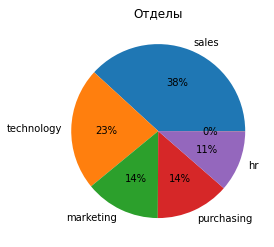

In [43]:
plot_pie_chart(X_test['dept'], 'Отделы')

Видим пропущенное значение (возможно в виде пробела), рассмотрим подробнее:


In [44]:
mask_ = X_test['dept'].str.match(r'\W+', na=False)
X_test[mask_]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
822186,,middle,medium,3,no,no,4,38400


In [45]:
X_test.loc[822186,'dept']

' '

Да, это действительно пробел, разберемся с ним также в пайплайне.

2. Столбец *level*

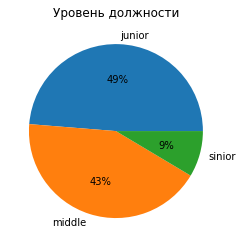

In [46]:
plot_pie_chart(X_test['level'], 'Уровень должности')

Соотношение примерно одинаковое с тренировочной выборкой.

3. Столбец *workload*

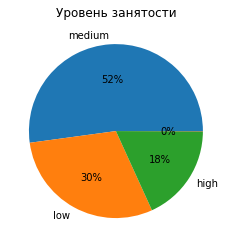

In [47]:
plot_pie_chart(X_test['workload'], 'Уровень занятости')

In [48]:
X_test['workload'].value_counts()

workload
medium    1043
low        593
high       363
             1
Name: count, dtype: int64

Видим пропущенное значение (возможно в виде пробела также), рассмотрим подробнее:

In [49]:
mask_ = X_test['workload'].str.match(r'\W+', na=False)
X_test[mask_]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
590867,marketing,junior,,4,no,no,4,28800


In [50]:
X_test.loc[590867,'workload']

' '

Действительно такой же пробел, как и в столбце с отделами. Разберемся с ним в пайплайнах

4. Столбец *employment_years*

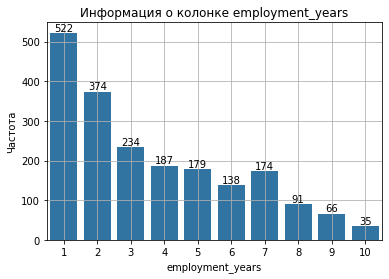

In [51]:
count_plot_('employment_years', X_test)

В принципе, распределение соотносится с тренировочными данными.

5. Столбец *last_year_promo*

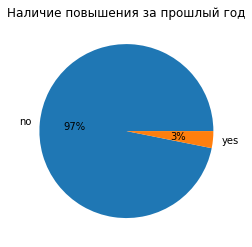

In [52]:
plot_pie_chart(X_test['last_year_promo'], 'Наличие повышения за прошлый год')

6. Столбец *last_year_violations*

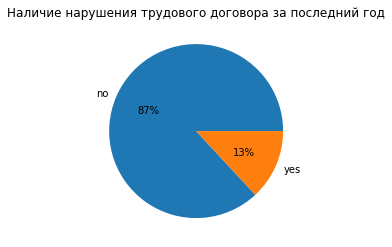

In [53]:
plot_pie_chart(X_test['last_year_violations'], 'Наличие нарушения трудового договора за последний год')

7. Столбец *salary*

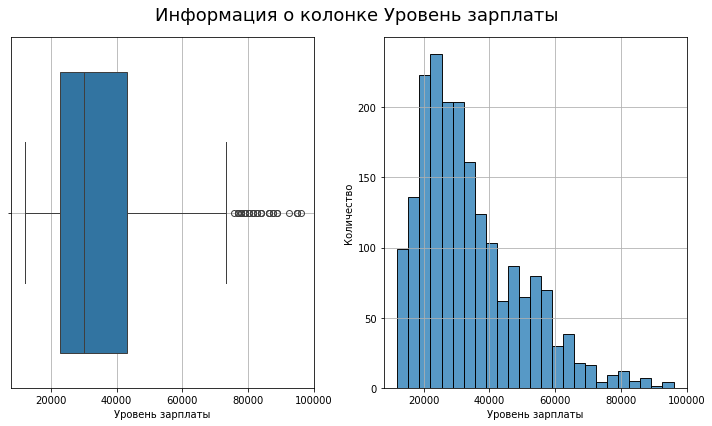

In [54]:
the_basic_plots(X_test, 'salary', 'Уровень зарплаты')

Аналогичное тренировочному распределение

8. Столбец *supervisor_evaluation*

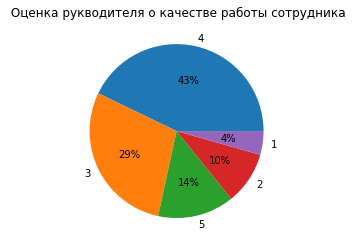

In [55]:
plot_pie_chart(X_test['supervisor_evaluation'], ' Оценка рукводителя о качестве работы сотрудника')

На 1% меньше неудовлетворенных оценок относительно тренировочного датафрейма.

**Вывод:**

Тестовый датасет по своему содержанию похож на тренировочный. В столбцах dept и level было по 1 пустому (с пробелом) значению, которые мы обработаем в пайплайне далее.

### <a id='toc2_3_'></a>Датафрейм y_test(test_target_job_satisfaction_rate.csv ) [&#8593;](#toc0_)

1. Загрузим датасет:

In [56]:
y_test = get_dataframe(['/datasets/test_target_job_satisfaction_rate.csv'])

In [57]:
y_test.head()


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


2. Посмотрим типы данных, пропуски и дубликаты:


In [58]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [59]:
print_nans_table(y_test)

+-----------------------+---------------------------------+
|        Признаки       | Пропущенное количество значений |
+-----------------------+---------------------------------+
|           id          |             0 (0.0%)            |
| job_satisfaction_rate |             0 (0.0%)            |
+-----------------------+---------------------------------+


In [60]:
y_test.duplicated().sum()

0

Пропусков нет, поэтому поставим *id* в индекс и превратим в серию:

In [61]:
y_test = y_test.set_index('id').sort_index()['job_satisfaction_rate']
y_test[:3]

id
100298   0.80
100480   0.84
100503   0.79
Name: job_satisfaction_rate, dtype: float64

In [62]:
y_test.isna().sum()

0

3. Посмотрим на распределение данного признака:

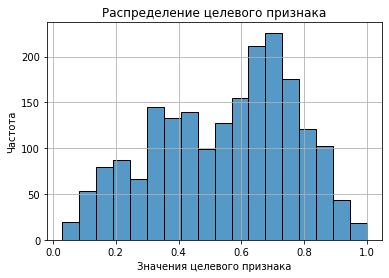

In [63]:
sns.histplot(y_test)
plt.xlabel('Значения целевого признака')
plt.ylabel('Частота')
plt.title('Распределение целевого признака')
plt.grid()
plt.show()

**Вывод**:

Данный датасет, состоящий из целевого признака, был обработан и преобразован в серию для удобства работы. Распределение целевого признака околонормальное с таким же смещением медианы вправо.

## <a id='toc3_'></a> Корреляционный анализ [&#8593;](#toc0_)

Для начала разделим колонки на соответствующие категории:

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


In [65]:
target = 'job_satisfaction_rate'

ohe_cols = [
    'dept'
]

ord_cols = [
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
   
]

num_cols = [
    'salary',
    'employment_years',
    'supervisor_evaluation'
]


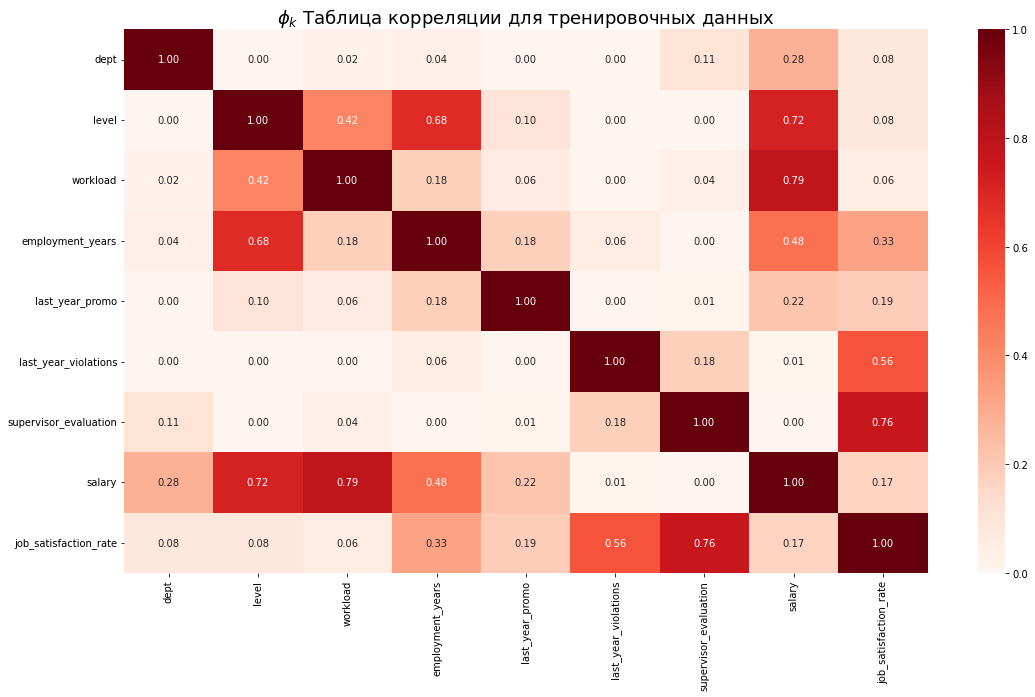

In [66]:
plt.figure(figsize=(18, 10))
sns.heatmap(train_df.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции для тренировочных данных', fontsize=18);

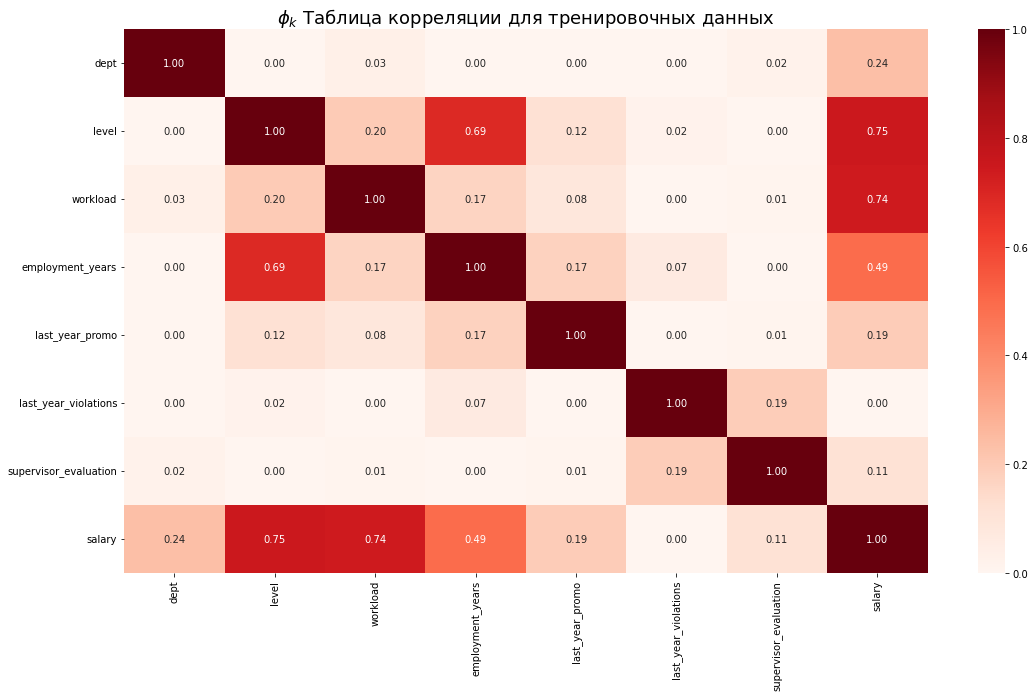

In [67]:
plt.figure(figsize=(18, 10))
sns.heatmap(X_test.phik_matrix(interval_cols=['salary']),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции для тестовых данных', fontsize=18);

**Выводы:**
1. По тренировочному датафрейму:

- Целевой признак коррелирует сильнее всего с признаком "Оценка руководителя", что логично. Также есть корреляция с "Нарушениями трудового договора", но утечкой, как мы предположили ранее, данный признак не является.
- Уровень зарплаты коррелирует с уровнем должности и загруженностью, что закономерно, однако корреляция не чрезмерная.
- Также понятной является корреляция уровня должности и количеством проработанных в компании лет.

2. По тестовому датафрейму:

- Есть несущественная закономерная корреляция между зарплатой и уровнями должностей, а также загруженностью. 
- Количество проработанных лет в компании также линейно связано с уровнем должности. 
Данные корректны, их можно скормить модели

В остальном линейной зависимости между признаками не наблюдаем.



## <a id='toc4_'></a> Построение моделей [&#8593;](#toc0_)

Дубликаты, обнаруженные выше, удалим, так как они могут повлиять на качество модели:

In [68]:
train_df = train_df.drop_duplicates()

In [69]:
train_df.duplicated().sum()

0

### <a id='toc4_1_'></a> Подготовка данных и построение пайплайнов[&#8593;](#toc0_)

In [70]:
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

Пайплайны:

In [71]:
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_ohe_1',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'SimpleImputer_before_ohe_2',
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [72]:
ord_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_ord_1',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

        (
            'SimpleImputer_before_ord_2',
            SimpleImputer(strategy='most_frequent', missing_values=' ')
        ),
        
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['no', 'yes']
                ],
                unknown_value=np.nan,
                handle_unknown='use_encoded_value'
            )
        ),
        
        (
            'SimpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [73]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
     ('ord', ord_pipe, ord_cols),
     ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

In [74]:
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [75]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
     # словарь для модели SVR()
    {
        'models': [SVR()],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [76]:
grid = GridSearchCV(
    final_pipe,
    param_grid=param_grid,
    scoring=smape
)

In [77]:
%%time
grid.fit(X_train, y_train);

CPU times: user 43.8 s, sys: 894 ms, total: 44.7 s
Wall time: 44.7 s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('SimpleImputer_before_ohe_1',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('SimpleImputer_before_ohe_2',
                                                                                          SimpleImputer(missing_values=' ',
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression(n_jobs=-1)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVR()],
                          'models__C': [0.01, 0.1, 1, 10, 100],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape_function, greater_is_better=False, response_method='predict'))

In [78]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_before_ohe_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_before_ohe_2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))...
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              ['no',
                                                                                               'yes'],
                                                                                              ['no',
                                                                                               'yes']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('SimpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', StandardScaler(),
                                                  ['salary', 'employment_years',
                                                   'supervisor_evaluation'])])),
                ('models', SVR(C=1))])

In [79]:
abs(grid.best_score_)

14.729548960269478

In [80]:
pd.DataFrame(grid.cv_results_)[['rank_test_score', 'param_models', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(7)

,rank_test_score,param_models,mean_test_score,params
45,1,SVR(),-14.73,"{'models': SVR(), 'models__C': 1, 'preprocessor__num': StandardScaler()}"
48,2,SVR(),-14.77,"{'models': SVR(), 'models__C': 10, 'preprocessor__num': StandardScaler()}"
51,3,SVR(),-16.09,"{'models': SVR(), 'models__C': 100, 'preprocessor__num': StandardScaler()}"
42,4,SVR(),-17.07,"{'models': SVR(), 'models__C': 0.1, 'preprocessor__num': StandardScaler()}"
30,5,KNeighborsRegressor(),-17.48,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 3, 'preprocessor__num': StandardScaler()}"
33,6,KNeighborsRegressor(),-17.54,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 4, 'preprocessor__num': StandardScaler()}"
27,7,KNeighborsRegressor(),-17.61,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 2, 'preprocessor__num': StandardScaler()}"


In [81]:
y_pred = grid.predict(X_test)
smape_function(y_test, y_pred)

13.829935195689663

Проверим модель на адекватность с помощью DummyRegressor:

In [82]:
final_pipe_dummy1 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',DummyRegressor())
    ]
)

final_pipe_dummy1.fit(X_train, y_train)
dummy_model_probas1 = final_pipe_dummy1.predict(X_test)
dummy_smape = smape_function(y_test, dummy_model_probas1)
print('SMAPE =', round(dummy_smape,2))

SMAPE = 38.26


Видим, что значение метрики SMAPE сильно хуже относительно модели SVR, и уж точно не вписывается в ограничения <=15.

### <a id='toc4_2_'></a> Анализ остатков [&#8593;](#toc0_)

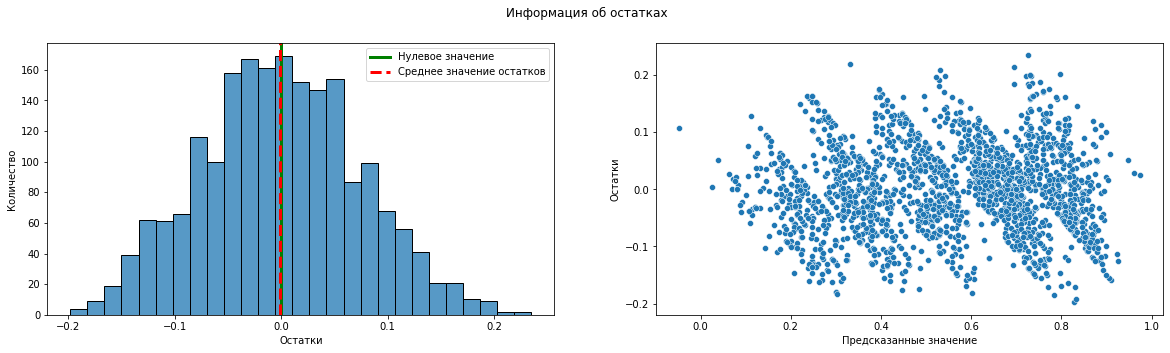

In [83]:
get_plots_about_residuals(y_test, y_pred)

**Вывод:**
- Были задействованы 4 модели в пайплайне с полным перебором параметров, в ходе которой выбрана лучшая - *SVR*(метод опорных векторов) с *StandardScaler* и гиперпараметром (коэффициентом для определения допустимых ошибок в присвоении значения) С = 1. Возможно это обусловлено непроизвольной тягой людей ставить оценки, близкие к десятым долям, что помогает модели строить  гиперплоскости в диапазонах круглых десятичных значений качественно (с оптимальными расстояниями до объектов) для обучения и, соответственно, присвоения значения предсказаний.
- Метрика SMAPE = 13,83 на тестовых данных, что удовлетворяет критерию успеха (<=15).
- Разброс остатков является нормальным и без смещений, дисперсия почти равномерная, учитывая тягу округлять оценку удовлетворенности у людей к десятым долям значений.


## <a id='toc5_'></a> Анализ важности признаков [&#8593;](#toc0_)

In [84]:
the_best_model = grid.best_estimator_.named_steps['models']
the_best_model

SVR(C=1)

In [85]:
X_train_transform = grid.best_estimator_.named_steps['preprocessor'].transform(X_train)

In [86]:
feature_names_ = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

In [87]:
#explainer = shap.Explainer(the_best_model.predict, X_train_transform, feature_names=feature_names_)

#shap_values = explainer(X_train_transform)

#shap.plots.beeswarm(shap_values, max_display=16,color_bar_label='Приоритетность признака в модели', show=False)
#plt.title('Влияние признаков на модель')
#plt.xlabel('Степень влияния признака')
#plt.ylabel('Признаки')
#plt.show()


Далее вставлен результат работы предыдущей ячейки в виде скриншота, так как она долго работает.

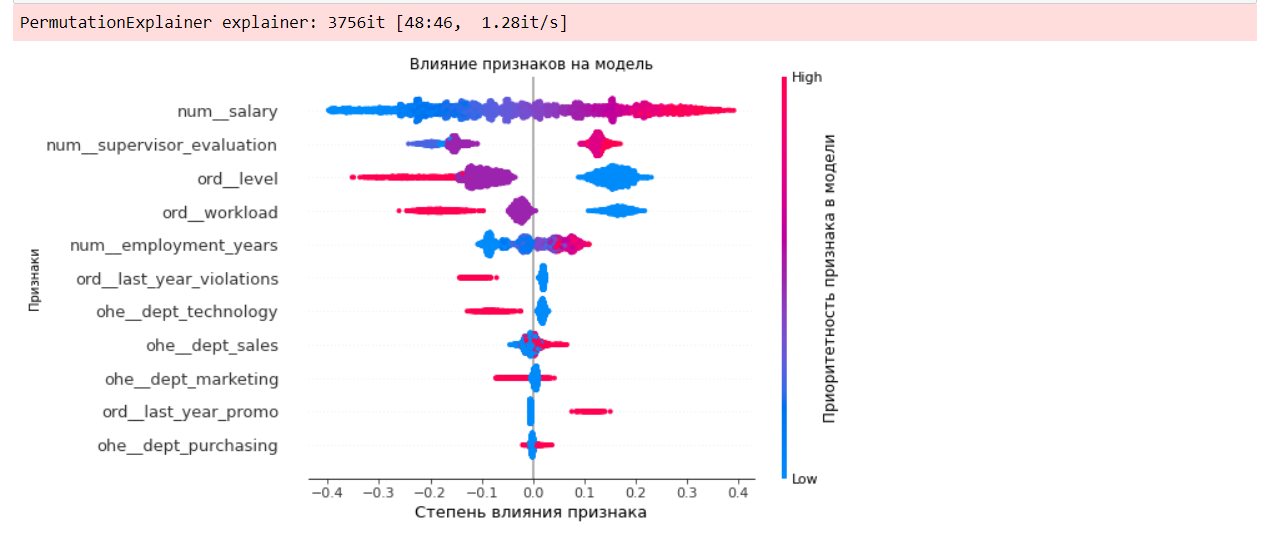

**Вывод:**

Наибольшая степень влияния у признаков 
- *Зарплата*. Чем она больше, тем больше сотрудник удовлетворен работой и наоборот.
- *Оценка руководителя* так же прямо пропорционально влияет на степень удовлетворенности. Возможно присутствует замкнутый круг: плохая оценка руководителя -> неудовлетворенность сотрудника -> плохое исполнение обязанностей-> еще более плохая оценка руководителя. Возможно стоит в таком случае проводить открытые мероприятия, где будут выстраиваться мероприятия, помогающие более четко организовать процессы и коммуникации.
-  *Уровень должности*. Однако здесь прослеживается обратно-пропорциональная зависимость: чем выше у людей должность, тем ниже удовлетворенность работой. Возможно задачи становятся слишком скучными или тяготит управленческая составляющая менее опытными сотрудниками. Стоит подробнее рассмотреть данный вопрос компании, потому что это чревато уходом квалифицированных кадров.
-  *Уровень загруженности*, как и следовало ожидать, влияет обратно пропорционально на степень удовлетворенности. Похоже, что многие именно "ходят на работу", а не работают.

Все остальные признаки менее влиятельны на целевой.

****Вторая задача проекта****

## <a id='toc6_'></a> Предобработка и исследовательский анализ данных(EDA) [&#8593;](#toc0_)

### <a id='toc6_1_'></a>Датафрейм train_df_2 (train_quit.csv) [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [88]:
train_df_2 = get_dataframe(['/datasets/train_quit.csv'])

In [89]:
train_df_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


2. Проверим типы данных:

In [90]:
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Все типы данных корректны

3. Рассмотрим пропуски:

In [91]:
print_nans_table(train_df_2)

+-----------------------+---------------------------------+
|        Признаки       | Пропущенное количество значений |
+-----------------------+---------------------------------+
|           id          |             0 (0.0%)            |
|          dept         |             0 (0.0%)            |
|         level         |             0 (0.0%)            |
|        workload       |             0 (0.0%)            |
|    employment_years   |             0 (0.0%)            |
|    last_year_promo    |             0 (0.0%)            |
|  last_year_violations |             0 (0.0%)            |
| supervisor_evaluation |             0 (0.0%)            |
|         salary        |             0 (0.0%)            |
|          quit         |             0 (0.0%)            |
+-----------------------+---------------------------------+


Пропусков нет

4. Посмотрим на дубликаты:

In [92]:
train_df_2.duplicated().sum()

0

Дубликатов полных нет, значит можем за индекс принять столбец id:

In [93]:
train_df_2 = train_df_2.set_index('id').sort_index()

In [94]:
train_df_2.duplicated().sum()

1413

Дубликаты есть, удалим их, так как они могут повлиять на качество модели:

In [95]:
train_df_2 = train_df_2.drop_duplicates()

In [96]:
train_df_2.duplicated().sum()

0

In [97]:
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2587 entries, 100222 to 999915
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2587 non-null   object
 1   level                  2587 non-null   object
 2   workload               2587 non-null   object
 3   employment_years       2587 non-null   int64 
 4   last_year_promo        2587 non-null   object
 5   last_year_violations   2587 non-null   object
 6   supervisor_evaluation  2587 non-null   int64 
 7   salary                 2587 non-null   int64 
 8   quit                   2587 non-null   object
dtypes: int64(3), object(6)
memory usage: 202.1+ KB


**Далее перейдем к исследованию распределений значений по столбцам(EDA).**

1. Столбец *dept*

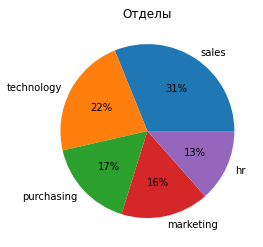

In [98]:
plot_pie_chart(train_df_2['dept'], 'Отделы')

2. Столбец *level*

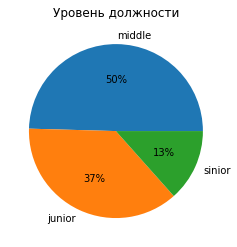

In [99]:
plot_pie_chart(train_df_2['level'], 'Уровень должности')

3. Столбец workload

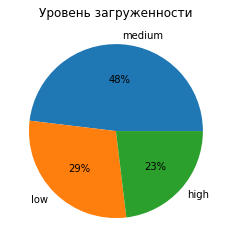

In [100]:
plot_pie_chart(train_df_2['workload'], 'Уровень загруженности')

4. Столбец employment_years

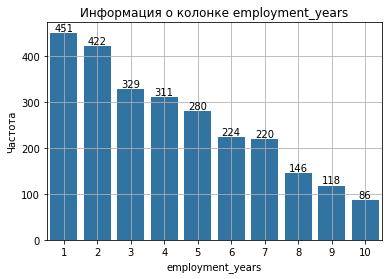

In [101]:
count_plot_('employment_years', train_df_2)

5. Столбец last_year_promo

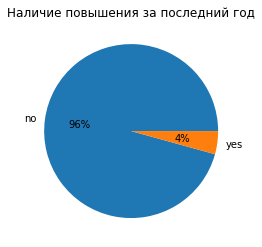

In [102]:
plot_pie_chart(train_df_2['last_year_promo'], 'Наличие повышения за последний год')

6. Столбец last_year_violations

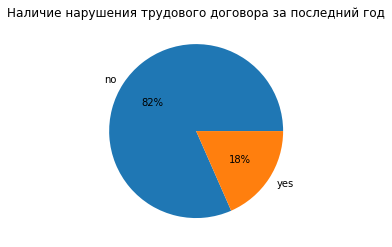

In [103]:
plot_pie_chart(train_df_2['last_year_violations'], 'Наличие нарушения трудового договора за последний год')

7. Столбец salary

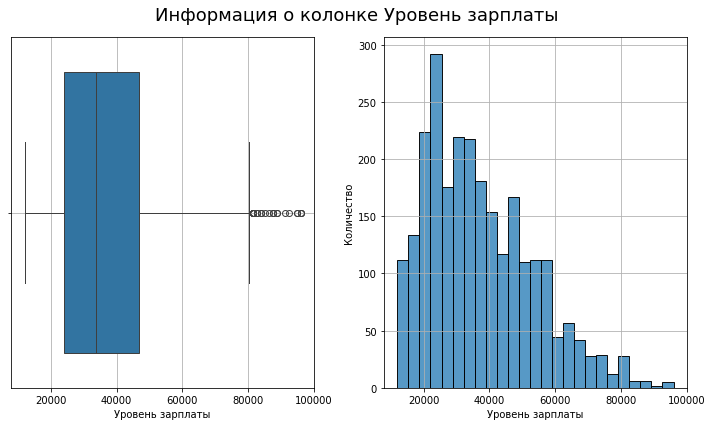

In [104]:
the_basic_plots(train_df_2, 'salary', 'Уровень зарплаты')

8. Столбец supervisor_evaluation

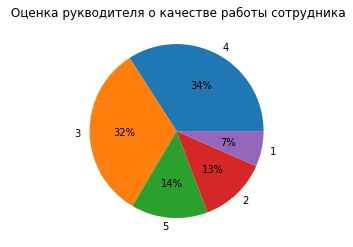

In [105]:
plot_pie_chart(train_df_2['supervisor_evaluation'], ' Оценка рукводителя о качестве работы сотрудника')

9. Столбец *quit*

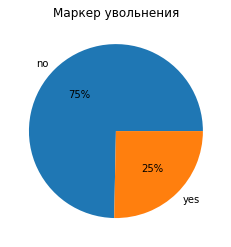

In [106]:
plot_pie_chart(train_df_2['quit'], 'Маркер увольнения')

Выделим данный признак как целевой и закодируем для использования далее:


In [107]:
target = 'quit'

X_train2 = train_df_2.drop(target, axis=1)
y_train2 = train_df_2[target]

In [108]:
label_encoder = LabelEncoder()
y_train2 = label_encoder.fit_transform(y_train2)

In [109]:
y_train2[:7]

array([1, 1, 0, 0, 1, 1, 0])

Признак успешно закодировался

**Выводы**:

Данный датафрейм похож на аналогичный в предыдущей задаче. Целевой признак не сбалансирован. Его мы закодировали с помощью *LabelEncoder*.

### <a id='toc6_2_'></a>Датафрейм y_test2 (test_target_quit) [&#8593;](#toc0_)

1. Загрузка данных и изучение:


In [110]:
y_test2 = get_dataframe(['/datasets/test_target_quit.csv'])

In [111]:
y_test2.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


2. Посмотрим типы данных, дубликаты и пропуски:

In [112]:
y_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [113]:
print_nans_table(y_test2)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|    id    |             0 (0.0%)            |
|   quit   |             0 (0.0%)            |
+----------+---------------------------------+


In [114]:
y_test2.duplicated().sum()

0

In [115]:
y_test2 = y_test2.set_index('id').sort_index()['quit']
y_test2[:3]

id
100298    no
100480    no
100503    no
Name: quit, dtype: object

3. Изучим распределение признака

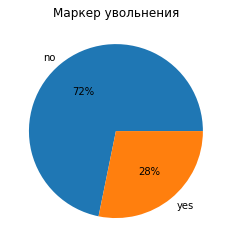

In [116]:
plot_pie_chart(y_test2, 'Маркер увольнения')

Закодируем целевой признак:

In [117]:
y_test2 = pd.Series(label_encoder.transform(y_test2), index=y_test2.index)

In [118]:
y_test2[:17]

id
100298    0
100480    0
100503    0
100610    0
100692    0
100710    0
100894    0
102102    0
102222    0
102320    0
103221    1
103278    0
103342    1
105159    1
105314    1
105761    0
105901    0
dtype: int64

### <a id='toc6_3_'></a>Портрет уволившегося сотрудника  [&#8593;](#toc0_)

In [119]:
_mask = y_train2 == 1
quit = X_train2[_mask]
not_quit = X_train2[~_mask]

len(quit), len(not_quit)

(655, 1932)

Далее посмотрим на признаки относительно уволившихся и не уволившихся сотрудников:


1. Отделы

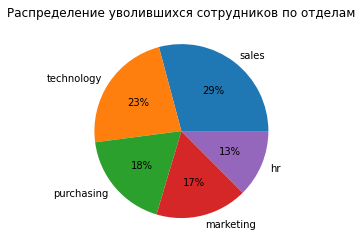

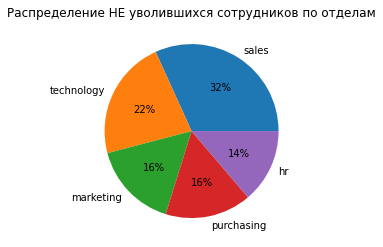

In [120]:
plot_pie_chart(quit['dept'], 'Распределение уволившихся сотрудников по отделам')
plot_pie_chart(not_quit['dept'], 'Распределение НЕ уволившихся сотрудников по отделам')

Из отдела маркетинга, снабжения и кадрового увольняются больше людей

2. Уровень должности:

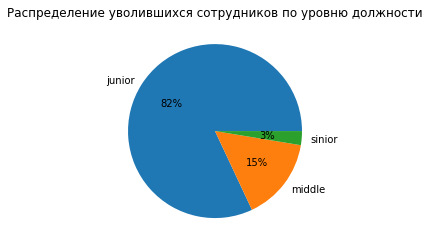

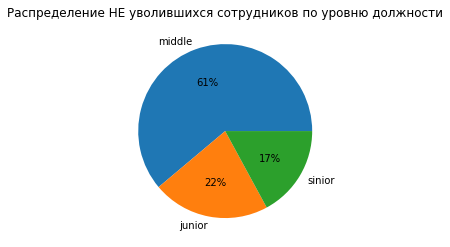

In [121]:
plot_pie_chart(quit['level'], 'Распределение уволившихся сотрудников по уровню должности')
plot_pie_chart(not_quit['level'], 'Распределение НЕ уволившихся сотрудников по уровню должности')

Большинство уволившихся сотрудников - начинающие специалисты. Большинство не уволившихся - среднего звена специалисты.

3. Уровень загруженности

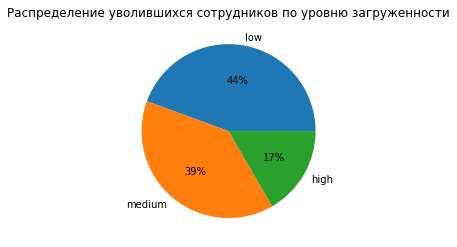

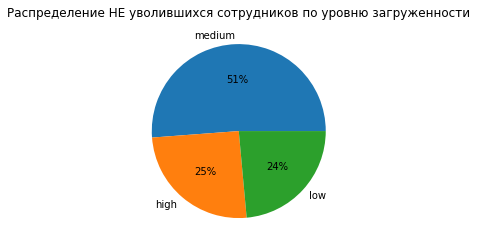

In [122]:
plot_pie_chart(quit['workload'], 'Распределение уволившихся сотрудников по уровню загруженности')
plot_pie_chart(not_quit['workload'], 'Распределение НЕ уволившихся сотрудников по уровню загруженности')

Здесь какой-то рациональной взаимосвязи не видим.

4. Нарушения трудового договора за последний год

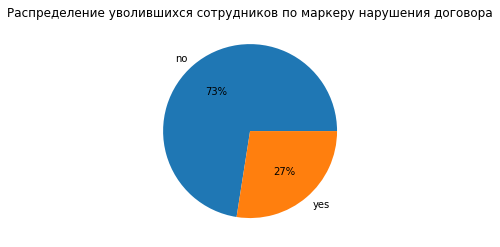

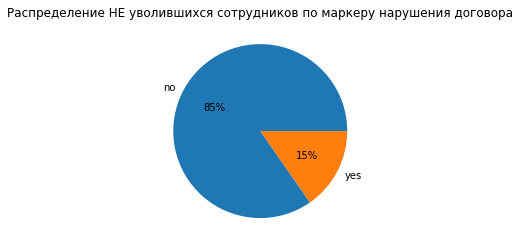

In [123]:
plot_pie_chart(quit['last_year_violations'], 'Распределение уволившихся сотрудников по маркеру нарушения договора')
plot_pie_chart(not_quit['last_year_violations'], 'Распределение НЕ уволившихся сотрудников по маркеру нарушения договора')

Нарушавших договор больше среди тех, кто  уволился. Такое бывает часто в компаниях

5. Оценка руководителя

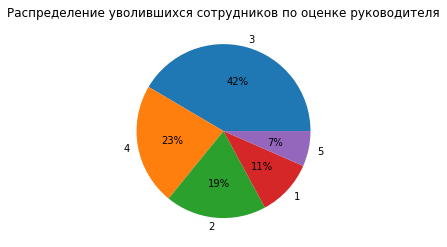

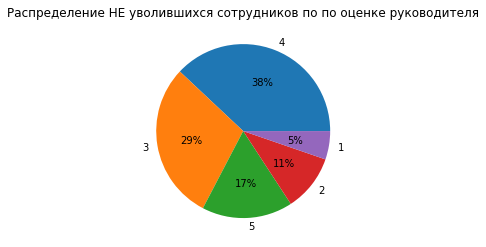

In [124]:
plot_pie_chart(quit['supervisor_evaluation'], 'Распределение уволившихся сотрудников по оценке руководителя')
plot_pie_chart(not_quit['supervisor_evaluation'], 'Распределение НЕ уволившихся сотрудников по по оценке руководителя')

Большинство уволившихся сотрудников были с нижней удовлетворительной оценкой руководителя.

6. Количество лет в компании('employment_years')

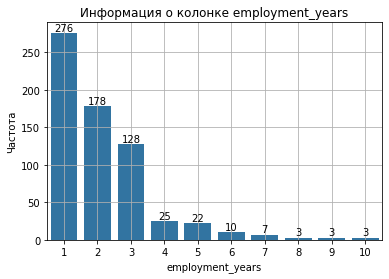

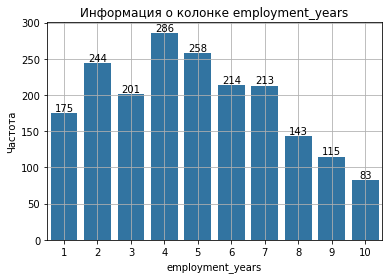

In [125]:
count_plot_('employment_years', quit)
count_plot_('employment_years', not_quit)

Большинство людей увольняются в первый год.

7. Посчитаем средние зарплаты:

In [126]:
quit.describe()

,employment_years,supervisor_evaluation,salary
count,655.00,655.00,655.00
mean,2.16,2.96,25767.94
std,1.50,1.05,10484.83
min,1.00,1.00,12000.00
25%,1.00,2.00,18000.00
50%,2.00,3.00,24000.00
75%,3.00,4.00,30600.00
max,10.00,5.00,79200.00


In [127]:
not_quit.describe()

,employment_years,supervisor_evaluation,salary
count,1932.00,1932.00,1932.00
mean,4.91,3.51,40952.17
std,2.53,1.06,16085.74
min,1.00,1.00,12000.00
25%,3.00,3.00,27600.00
50%,5.00,4.00,39000.00
75%,7.00,4.00,51600.00
max,10.00,5.00,96000.00


**Вывод:** 

Портрет уволившегося сотрудника может быть таким:

1) Молодой специалист *junior*

2) Проработавший 1-2 года в отделе маркетинга

3) Имеет среднюю оценку 3 от руководителя и относительно часто нарушает договор.

4) Зарплата 24-26 тыс.

### <a id='toc6_4_'></a>Влияние уровня удовлетворенности на увольнение  [&#8593;](#toc0_)

In [128]:
job_satisfaction_rate_test = y_test

In [129]:
job_satisfaction_rate_test[:20]

id
100298   0.80
100480   0.84
100503   0.79
100610   0.75
100692   0.69
100710   0.68
100894   0.49
102102   0.73
102222   0.66
102320   0.26
103221   0.30
103278   0.58
103342   0.25
105159   0.12
105314   0.24
105761   0.15
105901   0.75
108700   0.78
108816   0.12
109582   0.14
Name: job_satisfaction_rate, dtype: float64

In [130]:
_mask = y_test2 == 1
quit = job_satisfaction_rate_test[_mask]
not_quit = job_satisfaction_rate_test[~_mask]

In [131]:
quit[:20]

id
103221   0.30
103342   0.25
105159   0.12
105314   0.24
109582   0.14
109661   0.68
109800   0.39
110182   0.55
111132   0.24
111350   0.17
112822   0.56
115822   0.43
116186   0.55
122498   0.43
123080   0.18
130715   0.46
135704   0.11
135876   0.49
136193   0.17
136298   0.32
Name: job_satisfaction_rate, dtype: float64

In [132]:
not_quit[:20]

id
100298   0.80
100480   0.84
100503   0.79
100610   0.75
100692   0.69
100710   0.68
100894   0.49
102102   0.73
102222   0.66
102320   0.26
103278   0.58
105761   0.15
105901   0.75
108700   0.78
108816   0.12
111022   0.47
111415   0.38
111449   0.80
112724   0.24
114995   0.82
Name: job_satisfaction_rate, dtype: float64

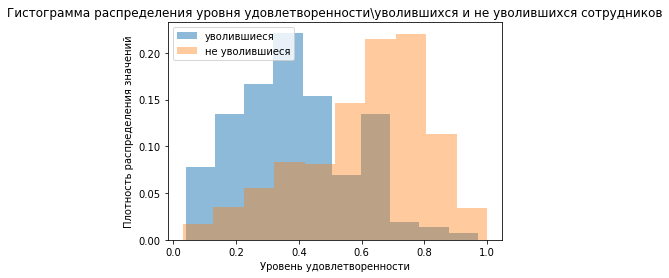

In [133]:
plt.hist(quit, alpha=0.5, label='уволившиеся', weights=np.ones_like(quit) / len(quit))
plt.hist(not_quit, alpha=0.4, label='не уволившиеся', weights=np.ones_like(not_quit) / len(not_quit))
plt.title('Гистограмма распределения уровня удовлетворенности\уволившихся и не уволившихся сотрудников')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Плотность распределения значений')
plt.legend()
plt.show()

**Вывод** понятен: В среднем уволившиеся сотрудники менее удовлетворены, напротив как удовлетворенность оставшихся сотрудников в среднем больше, значит утверждение аналитиков не отвергаем.

### <a id='toc6_5_'></a>Добавление нового признака  [&#8593;](#toc0_)

In [134]:
X_train2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400
100459,purchasing,junior,medium,3,no,no,3,21600
100469,marketing,junior,medium,1,no,no,4,28800
100601,technology,middle,high,4,no,no,4,68400
100858,sales,junior,medium,2,no,no,4,25200


In [135]:
X_train2['job_satisfaction_rate'] = grid.predict(X_train2)

In [136]:
X_train2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,0.37
100459,purchasing,junior,medium,3,no,no,3,21600,0.39
100469,marketing,junior,medium,1,no,no,4,28800,0.64
100601,technology,middle,high,4,no,no,4,68400,0.77
100858,sales,junior,medium,2,no,no,4,25200,0.76


## <a id='toc7_'></a> Корреляционный анализ [&#8593;](#toc0_)

In [137]:
target = 'quit'

num_cols = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate'
]

ohe_cols = [
    'dept'
]

ord_cols = [
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

In [138]:
df_ = X_train2.copy()
df_['quit'] = y_train2

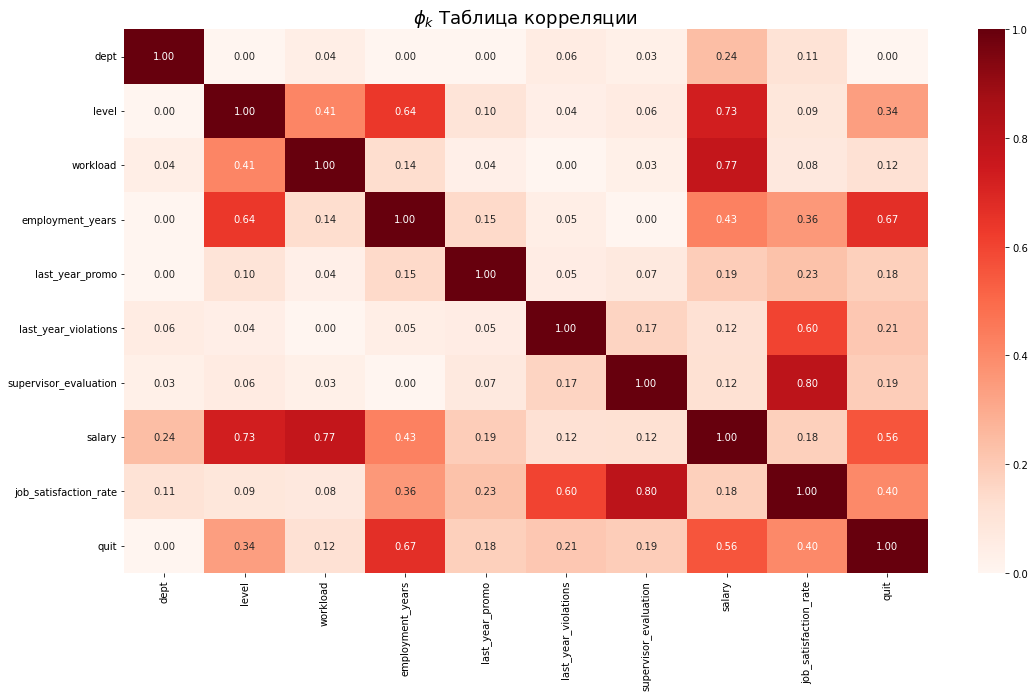

In [139]:
plt.figure(figsize=(18, 10))
sns.heatmap(df_.phik_matrix(interval_cols=num_cols+[target]),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции', fontsize=18);

**Вывод:**

- Целевой признак имеет небольшую корреляцию со стажем работы в компании и зарплатой
- Оценка руководителя коррелирует с удовлетворенностью работника, как мы выяснили ранее
- Так же как и в прошлом случае зарплата линейно связана с загруженностью

## <a id='toc8_'></a> Построение моделей [&#8593;](#toc0_)

 **Подготовка данных и построение пайплайнов**

In [140]:
data_preprocessor2 = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
     ('ord', ord_pipe, ord_cols),
     ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

In [141]:
final_pipe2  = Pipeline(
    [
        ('preprocessor', data_preprocessor2),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [142]:
param_grid2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
   {
        'models': [LogisticRegression(penalty='l1', solver='liblinear')],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 300, 500],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


In [143]:
grid2 = RandomizedSearchCV(
    final_pipe2,
    param_distributions=param_grid2,
    cv=5,
    n_iter=40,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [144]:
%%time
grid2.fit(X_train2, y_train2)

CPU times: user 2min 5s, sys: 782 ms, total: 2min 6s
Wall time: 2min 6s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_before_ohe_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('SimpleImputer_before_ohe_2',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unkn...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestClassifier(n_jobs=-1,
                                                                           random_state=42)],
                                         'models__max_depth': range(2, 11),
                                         'models__min_samples_leaf': range(1, 11),
                                         'models__min_samples_split': range(2, 11),
                                         'models__n_estimators': [100, 300,
                                                                  500],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [145]:
grid2.best_score_

0.9181280974306254

In [146]:
pd.DataFrame(grid2.cv_results_)\
    [['rank_test_score', 'param_models', 'mean_test_score', 'params']]\
    .sort_values(by='rank_test_score')\
    .head(7)

,rank_test_score,param_models,mean_test_score,params
5,1,"RandomForestClassifier(n_jobs=-1, random_state=42)",0.92,"{'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 100, 'models__min_samples_split': 10, 'models__min_samples_leaf': 6, 'models__max_depth': 6, 'models': RandomForestClassifier(n_jobs=-1, random_state=42)}"
29,2,"RandomForestClassifier(n_jobs=-1, random_state=42)",0.92,"{'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 100, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 6, 'models': RandomForestClassifier(n_jobs=-1, random_state=42)}"
38,3,"RandomForestClassifier(n_jobs=-1, random_state=42)",0.92,"{'preprocessor__num': 'passthrough', 'models__n_estimators': 100, 'models__min_samples_split': 4, 'models__min_samples_leaf': 4, 'models__max_depth': 5, 'models': RandomForestClassifier(n_jobs=-1, random_state=42)}"
16,4,"RandomForestClassifier(n_jobs=-1, random_state=42)",0.92,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 300, 'models__min_samples_split': 5, 'models__min_samples_leaf': 6, 'models__max_depth': 5, 'models': RandomForestClassifier(n_jobs=-1, random_state=42)}"
14,5,"RandomForestClassifier(n_jobs=-1, random_state=42)",0.92,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 500, 'models__min_samples_split': 9, 'models__min_samples_leaf': 2, 'models__max_depth': 6, 'models': RandomForestClassifier(n_jobs=-1, random_state=42)}"
15,6,"RandomForestClassifier(n_jobs=-1, random_state=42)",0.92,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 300, 'models__min_samples_split': 6, 'models__min_samples_leaf': 9, 'models__max_depth': 5, 'models': RandomForestClassifier(n_jobs=-1, random_state=42)}"
6,7,"RandomForestClassifier(n_jobs=-1, random_state=42)",0.92,"{'preprocessor__num': 'passthrough', 'models__n_estimators': 300, 'models__min_samples_split': 6, 'models__min_samples_leaf': 8, 'models__max_depth': 5, 'models': RandomForestClassifier(n_jobs=-1, random_state=42)}"


In [147]:
X_test2 = X_test.copy()

In [148]:
X_test2['job_satisfaction_rate'] = grid.predict(X_test)

In [149]:
X_test2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.84
100480,marketing,junior,low,4,no,no,4,16800,0.76
100503,purchasing,middle,high,5,no,no,4,55200,0.73
100610,sales,middle,medium,5,no,no,4,43200,0.81
100692,sales,middle,high,6,no,no,4,48000,0.68


In [150]:
y_pred2 = grid2.predict_proba(X_test2)[:, 1]
roc_auc_score(y_test2, y_pred2)

0.922909381852664

Проверим модель на адекватность:

In [151]:
final_pipe_dummy2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyClassifier(random_state=RANDOM_STATE))
    ]
)

final_pipe_dummy2.fit(X_train2, y_train2)
dummy_model_probas2 = final_pipe_dummy2.predict_proba(X_test2)[:,1]
dummy_roc2 = roc_auc_score(y_test2, dummy_model_probas2, )
print('ROC-AUC =', round(dummy_roc2,2))

ROC-AUC = 0.5


Метрика случайная, поэтому наша модель адекватна

**Вывод:**

- Были задействованы 5 моделей в пайплайне с полным перебором параметров, в ходе которой выбрана лучшая - *RandomForestClassifier* с *MinMaxScaler* и гиперпараметрами *models__min_samples_leaf': 6, 'models__max_depth': 6, min_samples_split=10*. Такой классификатор здесь оказался успешнее возможно потому, что его принцип "голосования" по каждому признаку находит правильное разбиение и соответственно более точно присваивает класс, учитывая еще и низкую корреляцию между признаками, что делает модель более конкуретноспособную по отношению к тем же линейным моделям.
- Метрика roc_auc = 0,918 на тренировочных данных и 0,923 на тестовых данных, что удовлетворяет критерию успеха (>=0,91).

Можем считать, что модель успешна.


## <a id='toc9_'></a> Анализ важности признаков [&#8593;](#toc0_)

In [152]:
the_best_model2 = grid2.best_estimator_.named_steps['models']
the_best_model2

RandomForestClassifier(max_depth=6, min_samples_leaf=6, min_samples_split=10,
                       n_jobs=-1, random_state=42)

In [153]:
X_train_transform2 = grid2.best_estimator_.named_steps['preprocessor'].transform(X_train2)

In [154]:
feature_names_2 = grid2.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

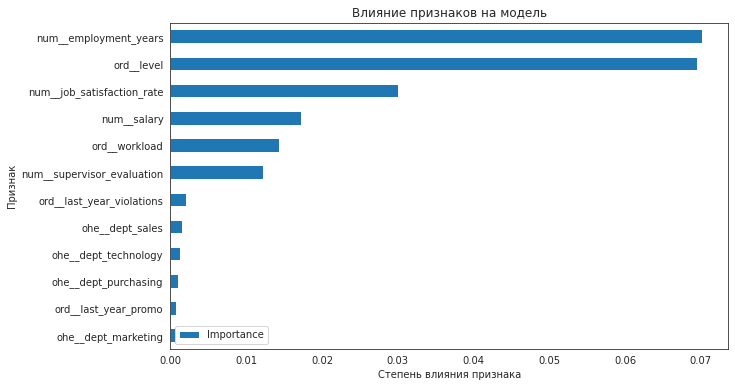

In [155]:
result = permutation_importance(
    the_best_model2,
    X_train_transform2,
    y_train2,
    scoring='roc_auc')

feature_importance = pd.DataFrame({'Feature': feature_names_2, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));
plt.title('Влияние признаков на модель')
plt.xlabel('Степень влияния признака')
plt.ylabel('Признак')
plt.legend();


**Вывод:**

Наибольшее влияние имеют такие признаки:

- *Количество проработанных лет в компании*. Чем больше человек проработал, тем больше вероятность, что он не уволится.
- *Уровень должности* так же положительно сказывается на желании человека продолжать работу.
- *Степень удовлетворенности*, как мы и выяснили, напрямую влияет на уход с рабочего места. Довольный сотрудник не покинет рабочее место более вероятно.
- *Уровень зарплаты*, что очевидно, влияет как на удовлетворенность сотрудника, так и на его радикальность в плане ухода с работы.

## <a id='toc10_'></a> Общий вывод [&#8593;](#toc0_)

В ходе проекта были решены 2 задачи:

- Построена модель, которая предсказала уровень удовлетворённости сотрудника на основе данных заказчика. 

- Построена модель, которая предсказала на основе данных заказчика уволится сотрудник из компании или нет.

Для построения моделей мы предобработали данные: изучили типы данных, пропуски, дубликаты. Было осуществлено большое количество исследовательских шагов для изучения закономерностей в данных.

Были созданы пайплайны для обработки признаков различных типов (числовые, категориальные номинальные и категориальные порядковые), а также заполнены пропуски с помощью SimpleImputer. Данные пайплайны были объединены в финальный с моделью через ColumnTransformer. С помощью инструментов  RandomizedSearchCV и GridSearchCV был выбран оптимальный метод подготовки данных, модель и гиперпараметры для нее.

**Первая задача проекта:**

Лучшая модель для задачи - *SVR*(метод опорных векторов) с *StandardScaler* и гиперпараметром (коэффициентом для определения допустимых ошибок в присвоении значения) С = 1 - показала метрику SMAPE = 13,83 на тестовых данных, что < 15 и удовлетворяет условию. Разброс остатков является нормальным и без смещений, что так же оправдывает актуальность модели

По влиянию признаков можно заметить такие закономерности:

- *Зарплата*. Чем она больше, тем больше сотрудник удовлетворен работой и наоборот.
 
- *Оценка руководителя* так же прямо пропорционально влияет на степень удовлетворенности. Возможно присутствует замкнутый круг: плохая оценка руководителя -> неудовлетворенность сотрудника -> плохое исполнение обязанностей-> еще более плохая оценка руководителя. Возможно стоит в таком случае проводить открытые мероприятия, где будут выстраиваться мероприятия, помогающие более четко организовать процессы и коммуникации.
- *Уровень должности*. Однако здесь прослеживается обратно-пропорциональная зависимость: чем выше у людей должность, тем ниже удовлетворенность работой. Возможно задачи становятся слишком скучными или тяготит управленческая составляющая менее опытными сотрудниками. Стоит подробнее рассмотреть данный вопрос компании, потому что это чревато уходом квалифицированных кадров.
- *Уровень загруженности*, как и следовало ожидать, влияет обратно пропорционально на степень удовлетворенности. Похоже, что многие именно "ходят на работу", а не работают.


**Вторая задача проекта:**

Был составлен портрет уволившегося сотрудника:

1) Молодой специалист *junior*
2) Проработавший 1-2 года в отделе маркетинга
3) Имеет среднюю оценку 3 от руководителя и относительно часто нарушает договор.

 Лучшая модель - *RandomForestClassifier* - показала метрику roc_auc = 0,918 на тренировочных данных и 0,923 на тестовых данных, что удовлетворяет критерию успеха (>=0,91).

Влияние на возможность увольнения сотрудника оказывают такие признаки:

- *Количество проработанных лет в компании*. Чем больше человек проработал, тем больше вероятность, что он не уволится.
- *Уровень должности* так же положительно сказывается на желании человека продолжать работу.
- *Степень удовлетворенности*, как мы и выяснили, напрямую влияет на уход с рабочего места. Довольный сотрудник не покинет рабочее место более вероятно.
- *Уровень зарплаты*, что очевидно, влияет как на удовлетворенность сотрудника, так и на его радикальность в плане ухода с работы.

Рекомендации бизнесу по поводу сокращения увольнений:

- Стоит проводить открытые мероприятия, где будут выстраиваться мероприятия, помогающие более четко организовать процессы и коммуникации. Руководители будут лучше понимать своиз подчиненных и наоборот.

- Исходя из портрета уволившегося сотрудника можно заметить, что большинство уходят с работы, не проработав и 3-х лет. Возможно для взращивания более зрелых кадров необходимо найти структурный подход к младшим сотрудникам, стимулировать их мотивацию с помощью сложных и интересных задач, за которыми кроются повышения как уровня должности, так и зарплат.

- Необходимо пересмотреть трудовые договоры сотрудников, обсудить, почему так много нарушений этих договоров и возможно лучше отбирать HR-отделам сотрудников на работу, чтобы потом не было текучки.
